<a href="https://colab.research.google.com/github/CRekkaran/Smart-Filter/blob/master/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
!pip3 install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip3 install cython pyyaml==5.1
!pip3 install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.2MB 57.6MB/s 
     |████████████████████████████████| 276kB 18.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200711-cp36-none-any.whl size=42285 sha256=26dc332db03affb029ce5f435e0f498f6877ad170beb836108979746fe6490f6
  Stored in directory: /root/.cache/pip/wheels/be/e2/ff/183aa84c45c7f0a6f55d2a40bdbfc00e9d5c36b492065ec526
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=40d7c4722efa3df0287bc141636744d9f2dd60fb2caf2911873d5b7dbeb9d179
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built fvcore pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 7

In [29]:
import torch, torchvision
import detectron2
# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow

from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import  GenericMask
from detectron2.data import MetadataCatalog

import tensorflow as tf
import json
import codecs
import requests
import urllib
import pandas as pd 
from PIL import Image
from tqdm import tqdm
from io import BytesIO
import itertools
import random
import os

from tensorflow import keras
from tensorflow.keras import layers

from google.colab.patches import cv2_imshow


In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

# Semantic Segmentation Predictor

In [4]:
def return_segmentation_predictor(modelname):
    from detectron2.config import get_cfg
    cfg = get_cfg()
    model = build_model(cfg)

    cfg.merge_from_file(model_zoo.get_config_file(modelname))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(modelname)

    predictor = DefaultPredictor(cfg)
    return predictor

# Smile Detection Predictor

In [9]:
def SmileModel(modelname):
    INPUT_SHAPE = (64, 64, 3)
    num_classes = 2
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.load_weights(modelname)
    return model

# smile_predictor = SmileModel('./smiledetection.h5')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
segment_predictor = return_segmentation_predictor("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
smile_predictor = SmileModel('/content/drive/My Drive/Colab Notebooks/smiledetection.h5')

In [27]:
def union_masks(im1, im2):
  assert(im1.shape == im2.shape)
  return im1 | im2

def return_attributes(path):
  im = cv2.imread(path)
  output = segment_predictor(im)

  SCORE_THRESHOLD = 0.7
  AREA_FRACTION_THRESHOLD = 0.1

  instances = output['instances']

  # storing attributes
  predictions = output["instances"].to("cpu")
  boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
  scores = predictions.scores if predictions.has("scores") else None
  classes = predictions.pred_classes if predictions.has("pred_classes") else None
  # labels = du._create_text_labels(classes, scores, v.metadata.get("thing_classes", None))
  keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get('coco_2017_train'), scale=0.3)
  if predictions.has("pred_masks"):
      masks = np.asarray(predictions.pred_masks)
      masks = [GenericMask(x, v.output.height, v.output.width) for x in masks]
  else:
    masks = None

  humans = (classes==0).nonzero().reshape(-1).numpy()
  temp = []
  for i in range(len(humans)):
    if(scores[humans[i]]>SCORE_THRESHOLD and masks[i].area()/(im.shape[0] * im.shape[1])>AREA_FRACTION_THRESHOLD):
      temp.append(humans[i])

  humans = temp

  human_masks = []

  for i in range(len(masks)):
    # if(i in humans):
    if(i in humans):
      human_masks.append(masks[i])

  # changing all boxes -> human boxes
  a = boxes.tensor.numpy()
  aa = np.array([])
  for i in humans:
    aa = np.append(aa, a[i])
  r, c = len(humans), (aa.shape[0]//len(humans))
  boxes.tensor = torch.from_numpy(aa.reshape(r, c))

  return im, human_masks, boxes

# boxes_array => a tuple containing x0, y0, x1, y1 coordinates, where x0 and y0 are the coordinates of the image's top left corner. x1 and y1 are the coordinates of the image's bottom right corner.
def bound_human_boxes(boxes):
  boxes_array = boxes.tensor.numpy()
  human_crop_images = []
  for i in boxes_array:
    x0, y0, x1, y1 = [int(x) for x in i]
    width = x1 - x0
    height = y1 - y0
    human_crop_images.append(im[y0:y1, x0:x1, :])

  return human_crop_images

def return_union_mask(im, human_masks):
  union_mask = human_masks[0].mask
  if len(human_masks)>1:
    for i in range(1, len(human_masks)):
      union_mask = union_masks(union_mask, human_masks[i].mask)
  return union_mask

def remove_bg(im, union_mask):
  temp = im
  h1_mask = union_mask
  for i in range(h1_mask.shape[0]):
    for j in range(h1_mask.shape[1]):
      if(h1_mask[i][j]==0):
        temp[i][j][:] = 255
  return temp

In [12]:
def addPreset(im, union_mask):
  # Add aesthetically pleasing color gradients [Till now, able to do for single color. horizontal direction only]
  # Try to add 2 colors, horizontally and vertically in a gradient fashion.
  temp = im
  h1_mask = union_mask
  
  for i in range(h1_mask.shape[0]):
    for j in range(h1_mask.shape[1]):
      
      if(h1_mask[i][j]==0):
        red = 255*(1-(j/h1_mask.shape[1]))
        temp[i][j] = [red, 255, 255]
  return temp  

In [15]:
def return_face_detection_predictor(filename):
    from detectron2.config import get_cfg

    MODEL_PATH = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
    cfg.MODEL.WEIGHTS = filename
    cfg.MODEL.RETINANET.NUM_CLASSES = 1
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.50
    
    return DefaultPredictor(cfg)

face_predictor = return_face_detection_predictor('/content/drive/My Drive/Colab Notebooks/checkpoint_face.pth')

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [50]:
font                   = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX
bottomLeftCornerOfText = (50,50)
fontScale              = 1
fontColor              = (0,0,255)
lineType               = 2

In [48]:
def ensemble(imagename):
    im, human_masks, boxes = return_attributes(imagename)
    final_mask = return_union_mask(im, human_masks)

    face_detection_output = face_predictor(im)
    pred_boxes = np.array(face_detection_output['instances']._fields['pred_boxes'].tensor.cpu(), dtype='int32')

    num_faces = pred_boxes.shape[0]
    prob_smiling_faces = []
    for i in pred_boxes:
        temp = im[i[1]:i[3],i[0]:i[2],:]
        temp = cv2.resize(temp, dsize=(64, 64))
        temp = temp.reshape(1, 64, 64, 3)
        proba = smile_predictor.predict(temp)
        prob_smiling_faces.append(proba[0][0]) # Smiling probability of each person

    prob_smiling_faces = np.array(prob_smiling_faces)
    index_smile_most = np.argmax(prob_smiling_faces) # Person smiling most
    smiling_prob_final = prob_smiling_faces[index_smile_most] # Smiling probability of person smiling most

    face_final = pred_boxes[index_smile_most]

    isSmiling = smiling_prob_final > 0.5
    if isSmiling:
        textOnImage = 'Smiling: ' + str('%.2f' % proba[0][0])
    else:
        textOnImage = 'Not Smiling: ' + str('%.2f' % proba[0][1])

    segmented_image = addPreset(im, final_mask)

    cv2.putText(segmented_image,textOnImage, 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
    lineType)
    padding_w = 10
    padding_h = 10

    x, y, w, h = face_final

    # PUTTING BOUNDING BOX ON IMAGE: BOX PREVIOUSLY CALCULATED USING CASCADE
    cv2.rectangle(im,(x,y),(w,h),(255,0,0),3)

    if((num_faces)>1):
        t1 ='They are '
    else:
        t1 = 'He/She is '
    if(isSmiling):
        t2 = 'smiling.'
    else:
        t2 = 'not smiling.'
    print(t1+t2)

    # IMSHOW FINAL IMAGE WITH FACE AND SMILE DETECTION
    cv2_imshow(im)

In [ ]:
!wget https://images.unsplash.com/photo-1494790108377-be9c29b29330?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80
!wget https://townsquare.media/site/442/files/2016/10/robertpattinson-e1477670950928.jpg?w=980&q=75

In [40]:
from PIL import Image
import requests
from io import BytesIO

def createThumbnail(filename):
  '''
    createThumbnail('me.jpg')
    creates lower resolution png format image
  '''
  from PIL import Image
  path = './'
  size = 1080, 1296
  im = Image.open(path+filename)
  im.thumbnail(size, Image.ANTIALIAS)
  im.save(path+filename.split('.')[0]+'.png', "PNG")

In [45]:
createThumbnail('robert.jpg')

He/She is smiling.


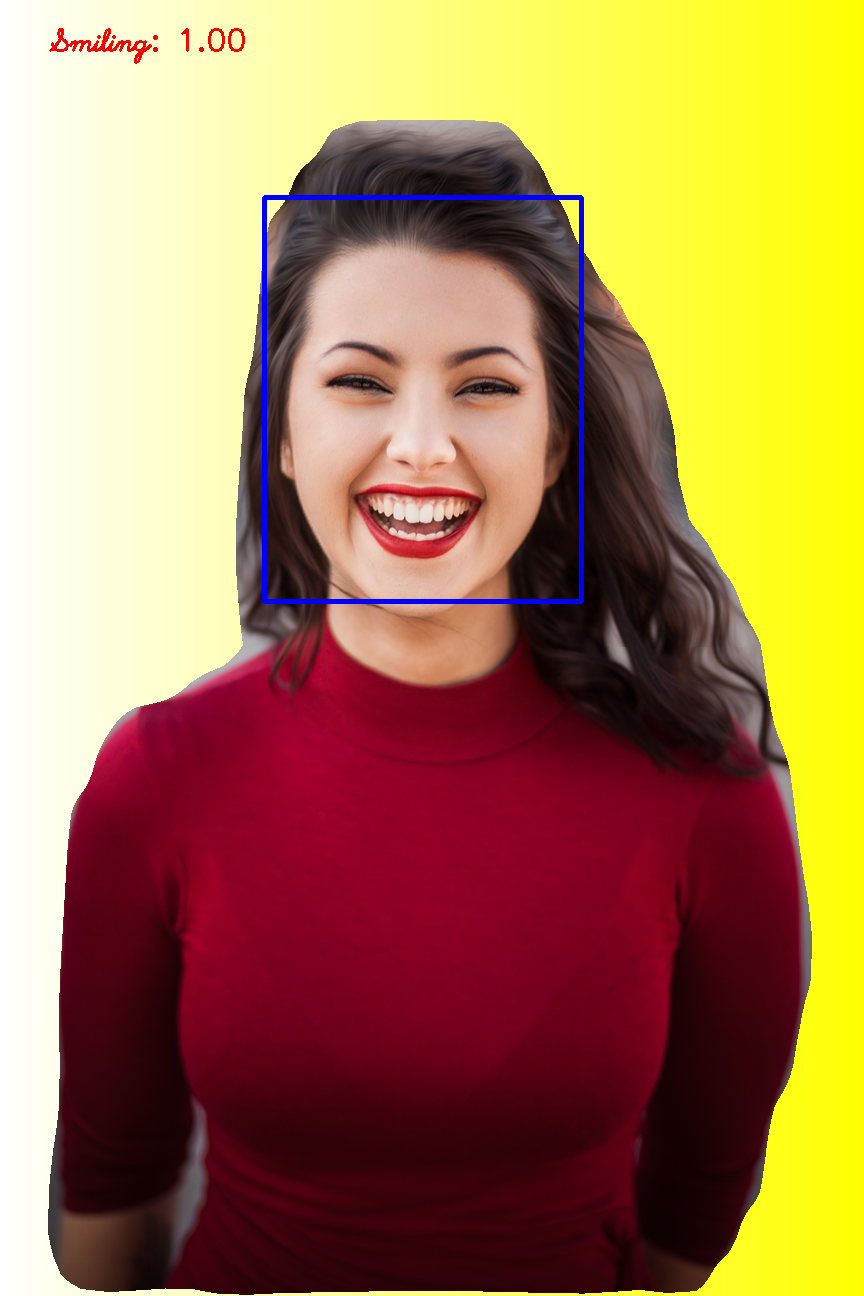

In [52]:
ensemble('selfie1.png')